# 04.PyTorch Custom Datasets Video Notebook
* เราเคยใช้ชุดข้อมูลบางอย่างกับ PyTorch มาก่อน

* แต่วิธีในการนำข้อมูลของคุณเข้าสู่ PyTorch คืออะไร?

* หนึ่งในวิธีที่ทำได้คือผ่าน: ชุดข้อมูลที่กำหนดเอง

Domain libraries

ขึ้นอยู่กับงานที่คุณกำลังทำอยู่ เช่น vision, text, audio,

แนะนำ คุณจะต้องดูไปที่ไลบรารีในโดเมนของ PyTorch แต่ละอันเพื่อหาฟังก์ชันการโหลดข้อมูลที่มีอยู่และฟังก์ชันการโหลดข้อมูลที่สามารถปรับแต่งได้

Resources:

Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/

Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0.Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn
torch.__version__

'2.5.1+cu121'

In [2]:
#set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Sun Dec 15 15:43:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1.Get data
* Food101 มีทั้งหมด 101 ประเภทอาหารต่างๆ และมีภาพจำนวน 1000 ภาพต่อประเภท (750 ในชุดฝึกฝนและ 250 ในชุดทดสอบ).

* ข้อมูลของเราเริ่มต้นด้วย 3 ประเภทอาหารและมีเพียง 10% ของภาพจากข้อมูลหลัก (~75 ในชุดฝึกฝนและ 25 ในชุดทดสอบ).

ทำไมถึงทำแบบนี้?

* เมื่อเริ่มโครงการเรียนรู้เชิงลึก (ML) ควรลองทำในขอบเขตขนาดเล็กก่อนแล้วค่อยเพิ่มขอบเขตเมื่อจำเป็น

จุดสำคัญคือเพื่อเร่งความเร็วในการทดลองในขั้นตอนต่างๆ

In [4]:
import requests
import zipfile
from pathlib import Path

#setup path to a data foder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path /"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2.Becoming one with the data (data preparation and data exploration)
เข้าใจข้อมูลให้ลึกซึ้ง (การเตรียมข้อมูลและการสำรวจข้อมูล)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
##ฟังก์ชันสำรวจโฟลเดอร์และแสดงจำนวนของไดเรกทอรีและไฟล์ภาพ

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [ ]:
#Setup path train/test
train_dir = image_path / "train"
test_dir = image_path / "test"
test_dir, train_dir

(PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi/train'))

### 2.1Visualizing and image
Let's write some code to:

Get all of the image paths
1. Pick a random image path using Python's random.choice()
2. Get the image class name using `pathlib.Path.parent.stem`
3. Since we're working with images, let's open the image with Python's PIL
4. We'll then show the image and print metadata

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/steak/355715.jpg
Image class: steak
Image height: 382
Image width: 512


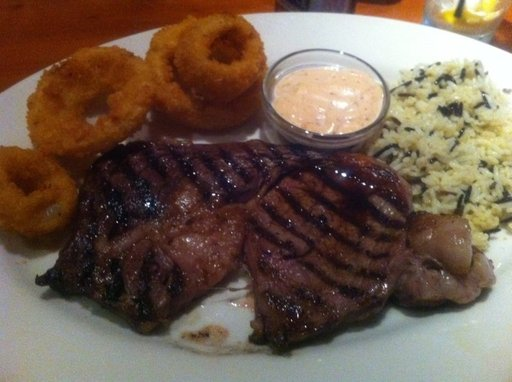

In [ ]:
import random
from PIL import Image
#set seed
random.seed(42)
#1 get all image paths
image_paths_list = list(image_path.glob("*/*/*.jpg")) ##เข้าถึงทุกรูปภาพทุกโพเดอร์
#2 pick a random image path
random_image_path = random.choice(image_paths_list)
# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# 4. Open image
img = Image.open(random_image_path)
#open image
img = Image.open(random_image_path)
# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


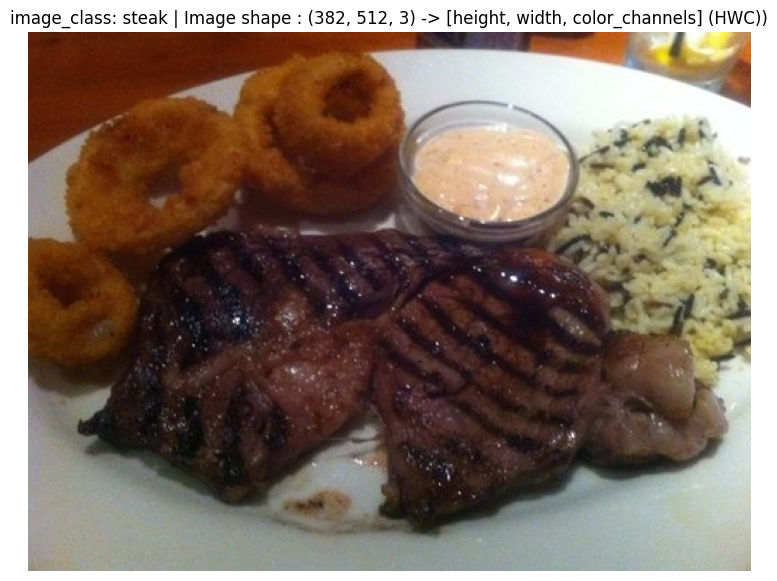

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#turn the img into an array
img_array  = np.asanyarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"image_class: {image_class} | Image shape : {img_array.shape} -> [height, width, color_channels] (HWC))")
plt.axis(False);

array([[[ 98,  33,  11],
        [ 93,  28,   6],
        [ 90,  28,   5],
        ...,
        [193, 143,  90],
        [192, 141,  86],
        [181, 130,  73]],

       [[ 96,  31,   9],
        [ 94,  29,   7],
        [ 92,  30,   7],
        ...,
        [197, 146,  93],
        [199, 147,  90],
        [193, 141,  83]],

       [[ 93,  31,  10],
        [ 93,  31,  10],
        [ 94,  32,  11],
        ...,
        [194, 141,  87],
        [197, 142,  85],
        [194, 138,  79]],

       ...,

       [[150, 143, 125],
        [153, 146, 128],
        [151, 142, 125],
        ...,
        [173, 167, 145],
        [180, 174, 150],
        [175, 169, 143]],

       [[150, 143, 124],
        [151, 144, 125],
        [149, 140, 123],
        ...,
        [172, 165, 139],
        [179, 172, 144],
        [172, 165, 137]],

       [[149, 142, 123],
        [149, 142, 123],
        [146, 137, 120],
        ...,
        [171, 164, 136],
        [177, 170, 141],
        [170, 163, 134]]], dtype=uint8)
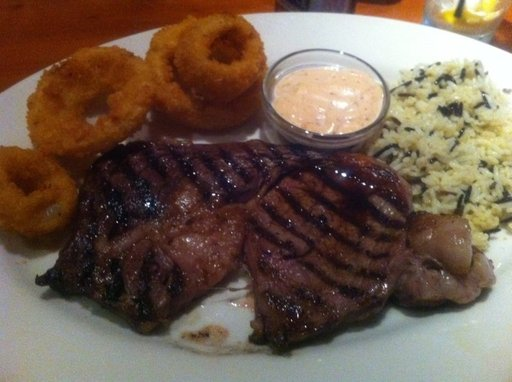

In [ ]:
img_array

## 3.Transforming data
Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader.

In [ ]:
import torch
from torch.utils.data import dataloader
from torchvision import datasets, transforms

### 3.1Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [ ]:
#Write a transform for image
data_transform = transforms.Compose({
    #Resize img to 64x64
    transforms.Resize(size=(64,64)),
    #filp the img randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn umg into a torch.tensor
    transforms.ToTensor()
})

In [ ]:
data_transform(img)

tensor([[[0.3611, 0.3375, 0.3313,  ..., 0.9618, 0.8173, 0.7596],
         [0.3583, 0.3349, 0.3396,  ..., 0.9263, 0.8106, 0.7749],
         [0.3657, 0.3580, 0.3653,  ..., 0.9297, 0.7804, 0.7661],
         ...,
         [0.6248, 0.6349, 0.6465,  ..., 0.7388, 0.7373, 0.7298],
         [0.6218, 0.6297, 0.6455,  ..., 0.7190, 0.7174, 0.7115],
         [0.6098, 0.6210, 0.6298,  ..., 0.7039, 0.7018, 0.7010]],

        [[0.1241, 0.1239, 0.1135,  ..., 0.9139, 0.6697, 0.5542],
         [0.1190, 0.1091, 0.1090,  ..., 0.8579, 0.6548, 0.5213],
         [0.1297, 0.1203, 0.1218,  ..., 0.8725, 0.6219, 0.4478],
         ...,
         [0.5994, 0.6085, 0.6168,  ..., 0.7423, 0.7429, 0.7410],
         [0.5863, 0.5959, 0.6125,  ..., 0.7370, 0.7269, 0.7153],
         [0.5702, 0.5862, 0.6075,  ..., 0.7313, 0.7180, 0.6896]],

        [[0.0417, 0.0346, 0.0270,  ..., 0.3810, 0.3672, 0.3417],
         [0.0407, 0.0272, 0.0275,  ..., 0.3935, 0.4104, 0.2870],
         [0.0339, 0.0288, 0.0297,  ..., 0.5487, 0.4167, 0.

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



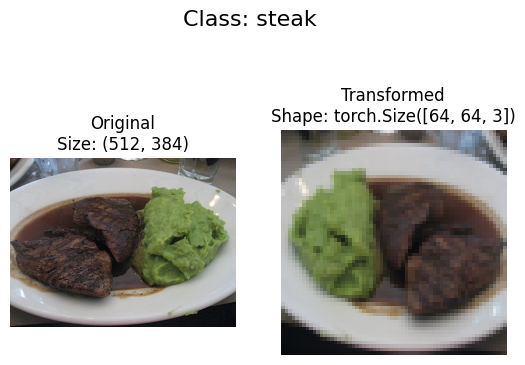

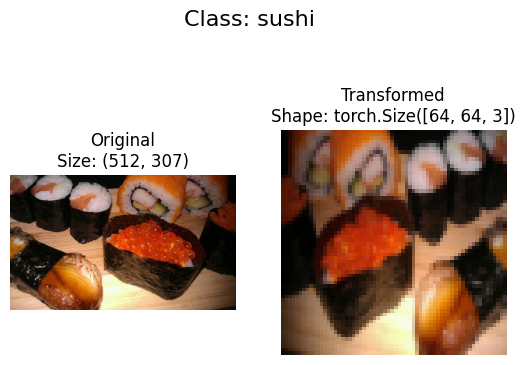

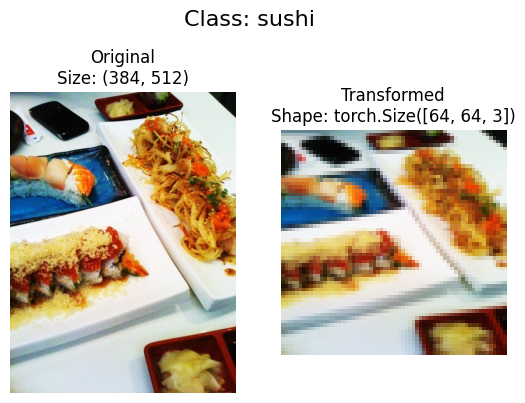

In [ ]:
plot_transformed_images(image_paths=image_paths_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


##4.Option 1: Loading image data using ImageFolder
We can load image classification data using torchvision.datasets.ImageFolder - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [ ]:
#Use ImageFolder to create dataset(S)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = data_transform)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                RandomHorizontalFlip(p=0.5)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                RandomHorizontalFlip(p=0.5)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
            ))

#### โค้ดนี้ใช้ `torchvision.datasets.ImageFolder`
เพื่อโหลดข้อมูลรูปภาพสำหรับการฝึกและการทดสอบจากไดเรกทอรีที่ระบุ โดยใช้การแปลงข้อมูลที่กำหนด:

### รายละเอียดโค้ด:
```python
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data, test_data
```

### วิธีการทำงาน:
1. **Import `datasets` จาก `torchvision`**:
   ```python
   from torchvision import datasets
   ```
   - นำเข้าโมดูล `datasets` จากไลบรารี `torchvision` ซึ่งมีฟังก์ชันสำหรับโหลดชุดข้อมูลที่ใช้กับ PyTorch.

2. **สร้าง `train_data`**:
   ```python
   train_data = datasets.ImageFolder(root=train_dir,
                                     transform=data_transform,
                                     target_transform=None)
   ```
   - **root=train_dir**: ระบุไดเรกทอรีที่มีภาพสำหรับการฝึก (`train_dir`).
   - **transform=data_transform**: ระบุฟังก์ชันการแปลงข้อมูลที่จะใช้กับภาพทุกภาพในชุดข้อมูลการฝึก (เช่นการปรับขนาด, การครอบ, การแปลงสี).
   - **target_transform=None**: ไม่ใช้การแปลงข้อมูลกับ target (ป้ายชื่อของภาพ).

3. **สร้าง `test_data`**:
   ```python
   test_data = datasets.ImageFolder(root=test_dir,
                                    transform=data_transform)
   ```
   - **root=test_dir**: ระบุไดเรกทอรีที่มีภาพสำหรับการทดสอบ (`test_dir`).
   - **transform=data_transform**: ใช้ฟังก์ชันการแปลงข้อมูลเดียวกันกับที่ใช้ในชุดข้อมูลการฝึก.

### การใช้งาน:
- **train_data**: ชุดข้อมูลการฝึกที่โหลดจาก `train_dir` พร้อมกับการแปลงข้อมูลตามที่ระบุ.
- **test_data**: ชุดข้อมูลการทดสอบที่โหลดจาก `test_dir` พร้อมกับการแปลงข้อมูลตามที่ระบุ.

โค้ดนี้ช่วยให้คุณสามารถโหลดและแปลงข้อมูลภาพจากไดเรกทอรีที่จัดเก็บข้อมูลได้ง่ายและมีประสิทธิภาพ โดยสามารถนำ `train_data` และ `test_data` ไปใช้ในการฝึกและทดสอบโมเดลการเรียนรู้เชิงลึกได้โดยตรง

In [ ]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
#list
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [ ]:
#get class name as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
#check the len of dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
#index on the train_data dataset to get a single img and label
img, label = train_data[0][0], train_data[0][1]
img, label
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
 tensor([[[0.1193, 0.1200, 0.1241,  ..., 0.0997, 0.1035, 0.1123],
         [0.1303, 0.1303, 0.1291,  ..., 0.0969, 0.0958, 0.1042],
         [0.1338, 0.1342, 0.1348,  ..., 0.0960, 0.0965, 0.1022],
         ...,
         [0.1688, 0.1636, 0.1687,  ..., 0.1236, 0.1095, 0.1088],
         [0.1699, 0.1653, 0.1688,  ..., 0.1105, 0.0953, 0.0889],
         [0.1665, 0.1647, 0.1692,  ..., 0.0990, 0.0875, 0.0861]],

        [[0.0607, 0.0604, 0.0596,  ..., 0.0755, 0.0722, 0.0725],
         [0.0639, 0.0639, 0.0639,  ..., 0.0733, 0.0723, 0.0726],
         [0.0700, 0.0705, 0.0717,  ..., 0.0724, 0.0741, 0.0710],
         ...,
         [0.2373, 0.2405, 0.2505,  ..., 0.1393, 0.1322, 0.1238],
         [0.2326, 0.2377, 0.2517,  ..., 0.1258, 0.1170, 0.1108],
         [0.2283, 0.2354, 0.2443,  ..., 0.1147, 0.1038, 0.1029]],

        [[0.0218, 0.0214, 0.0171,  ..., 0.0914, 0.0906, 0.0944],
         [0.0175, 0.0174, 0.0184,  ..., 0.0900, 0.0885, 0.0911],
         [0.0186, 0.0141, 0.0147,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

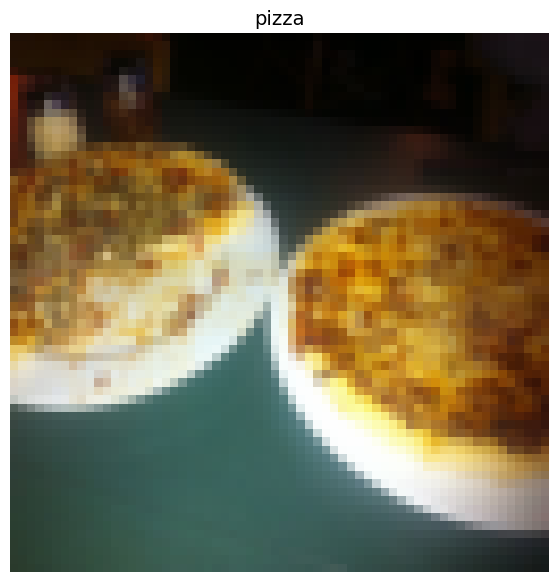

In [ ]:
# Convert the image to a format compatible with matplotlib
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_name[label], fontsize=14)

### 4.1Turn loaded images into DataLoader's
A `DataLoader` is going to help us turn our `Dataset'`s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
#turn train and test datasets into dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_data,
                                         batch_size=BATCH_SIZE,
                                         num_workers=1,
                                         shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                                         batch_size=BATCH_SIZE,
                                         num_workers=1,
                                         shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bf855fc7460>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf855fc7f10>)

In [ ]:
len(train_dataloader),len(test_dataloader)

(4, 2)

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [BATCH_SIZE, Color_chanels,height,width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 3, 64, 64]) -> [BATCH_SIZE, Color_chanels,height,width]
Label shape: torch.Size([64])


##5 Option 2: Loading Image Data with a Custom Dataset
* Want to be able to load images from file
* Want to be able to get class names from the Dataset
* Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-built Dataset functions

Cons:

Even though you could create Dataset out of almost anything, it doesn't mean it will work...
Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues
All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset




วิธีโหลดภาพจากไฟล์และทำงานกับ Dataset กำหนดเอง

คุณต้องการ:

* โหลดภาพจากไฟล์
* ดึงชื่อคลาสจาก Dataset
* ดึงคลาสเป็นพจนานุกรมจาก Dataset

ข้อดี:
* สามารถสร้าง Dataset จากเกือบทุกอย่างได้
* ไม่จำกัดเพียงฟังก์ชัน Dataset ที่สร้างไว้แล้วใน PyTorch

ข้อเสีย:

* แม้ว่าจะสร้าง Dataset จากเกือบทุกอย่างได้
* แต่นั่นไม่ได้หมายความว่ามันจะทำงานได้เสมอไป...
การใช้ Dataset ที่กำหนดเองมักจะทำให้ต้องเขียนโค้ดมากขึ้น ซึ่งอาจมีแนวโน้มที่จะเกิดข้อผิดพลาดหรือปัญหาด้านประสิทธิภาพ

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from typing import Tuple, Dict,List

In [ ]:
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
We want a function to:

1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).

3. Turn the class names into a dict and a list and return them.

คุณสามารถสร้างฟังก์ชันช่วย (helper function) เพื่อดึงชื่อคลาสจากไดเรกทอรีโดยใช้ os.scandir() และทำตามเงื่อนไขที่กำหนดได้ดังนี้:

1. ใช้ os.scandir() เพื่อ travers ไดเรกทอรีที่ระบุ.

2. ตรวจสอบว่ามีชื่อคลาสในไดเรกทอรีหรือไม่ ถ้าไม่มีให้แจ้งข้อผิดพลาด.

3. แปลงชื่อคลาสเป็นพจนานุกรมและลิสต์แล้วคืนค่า.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
 def find_classes(directories: str) -> Tuple[List[str], Dict[str,int]]:
  """
  Find class foder name in a target directory.
  ค้นหาชื่อโฟลเดอร์คลาสในไดเรกทอรีเป้าหมาย
  """
  #1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directories) if entry.is_dir())
  #2. Raise an error if class names could not be found
  if not classes:
    raise OSError(f"Could not find any classes in {directories}...")
  #3.create a dict of index lables
  class_to_idx = {class_name: i for i,class_name in enumerate(train_data.classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###5.2 Create a custom Dataset to replicate ImageFolder

To create our own custom dataset, we want to:

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
 * paths - paths of our images
 * transform - the transform we'd like to use
 * classes - a list of the target classes
 * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images(), this function will open an image
5. Overwrite the __len()__ method to return the length of our dataset
6. Overwrite the __getitem()__ method to return a given sample when passed an index

ในการสร้างชุดข้อมูลที่กำหนดเอง เราต้องการ:

1. สร้างคลาสย่อยจาก `torch.utils.data.Dataset`
2. เริ่มต้นคลาสย่อยของเราด้วยไดเรกทอรีเป้าหมาย (ไดเรกทอรีที่เราต้องการดึงข้อมูลจาก) รวมทั้งการแปลงข้อมูลถ้าเราต้องการแปลงข้อมูลของเรา
3. สร้างแอตทริบิวต์หลายตัว:
   * `paths` - พาธของรูปภาพของเรา
   * `transform` - การแปลงข้อมูลที่เราต้องการใช้
   * `classes` - รายการของคลาสเป้าหมาย
   * `class_to_idx` - พจนานุกรมของคลาสเป้าหมายที่แมปกับป้ายชื่อที่เป็นตัวเลข
4. สร้างฟังก์ชัน `load_images()` ซึ่งจะเปิดภาพ
5. เขียนทับเมธอด `__len__()` เพื่อคืนค่าความยาวของชุดข้อมูลของเรา
6. เขียนทับเมธอด `__getitem__()` เพื่อคืนค่าตัวอย่างเมื่อส่งผ่านดัชนี

In [ ]:
import pathlib # import the pathlib module
from torch.utils.data import Dataset
#1. subclass torch.unitls.data.Dataset
class CustomImageDataset(Dataset):
  #2. Initialize our custom dataset
  def __init__(self,targ_dir: str,
               transforms=None):
    #3.create class attributes
    #Get all of img paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #setup transform
    self.transform = transforms
    #create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)
  #4. create a function to load img
  def load_image(self,index: int) -> Image.Image:
    "Opens an img via a path and return it."
    image_path = self.paths[index]
    return Image.open(image_path)
  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [ ]:
#create a transform
from torchvision import transforms
train_transform = transforms.Compose({
    #Resize img to 64x64
    transforms.Resize(size=(64,64)),
    #filp the img randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn umg into a torch.tensor
    transforms.ToTensor()
 })
test_transform = transforms.Compose({
    #Resize img to 64x64
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
})



In [ ]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [ ]:
# test CustomImageDataset
train_data_custom = CustomImageDataset(targ_dir=train_dir,
                                       transforms=train_transform)
test_data_custom = CustomImageDataset(targ_dir=test_dir,
                                       transforms=test_transform)


In [ ]:
train_data_custom,test_data_custom

(<__main__.CustomImageDataset at 0x7bf855fdf820>,
 <__main__.CustomImageDataset at 0x7bf855fdecb0>)

In [ ]:
len(train_data),len(train_data_custom)

(225, 225)

In [ ]:
len(test_data),len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:

# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)


True
True


###5.3 Create a function to display random images
1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:

# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

In [ ]:
# 1.สร้างฟังก์ชัน: รับ dataset เป็นพารามิเตอร์หลักพร้อมพารามิเตอร์เสริมอื่นๆ.
# 2. ปรับจำนวนภาพที่แสดง: ถ้า n มากกว่า 10 ให้ตั้งค่า n เป็น 10 และปิดการแสดงผลรูปร่างของภาพ.
# 3. ตั้งค่า seed: ถ้ามีการกำหนด seed เพื่อความสามารถในการทำซ้ำได้ของการสุ่ม.
# 4. เลือกดัชนีตัวอย่างแบบสุ่ม: ใช้ random.sample เพื่อเลือกดัชนีแบบสุ่ม n ตัวจากชุดข้อมูล.
# 5. ตั้งค่าการ plot: สร้างกราฟิกขนาดใหญ่ขึ้นเพื่อแสดงภาพหลายๆ ภาพ.
# 6. วนลูปผ่านดัชนีแบบสุ่มและ plot ภาพ: สำหรับแต่ละดัชนีที่สุ่มมา ให้โหลดภาพและป้ายชื่อจากชุดข้อมูล.
# 7. ปรับเปลี่ยนมิติเพื่อการ plot: เปลี่ยนมิติของภาพจาก [color_channels, height, width] เป็น [height, width, color_channels] เพื่อใช้กับ matplotlib.

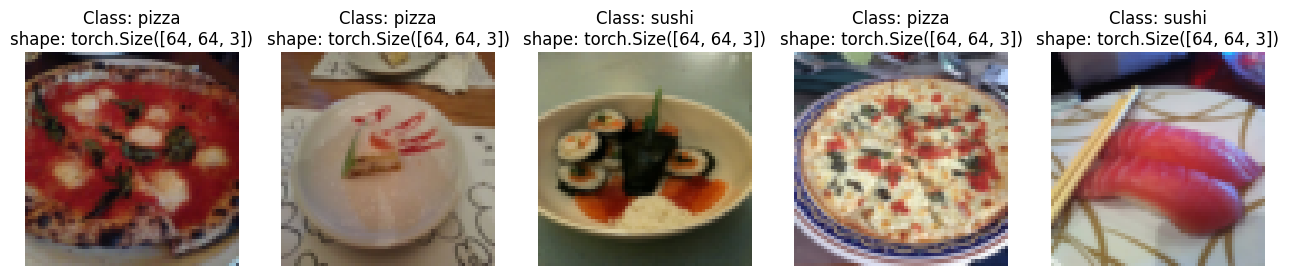

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_name,
                      seed=None)

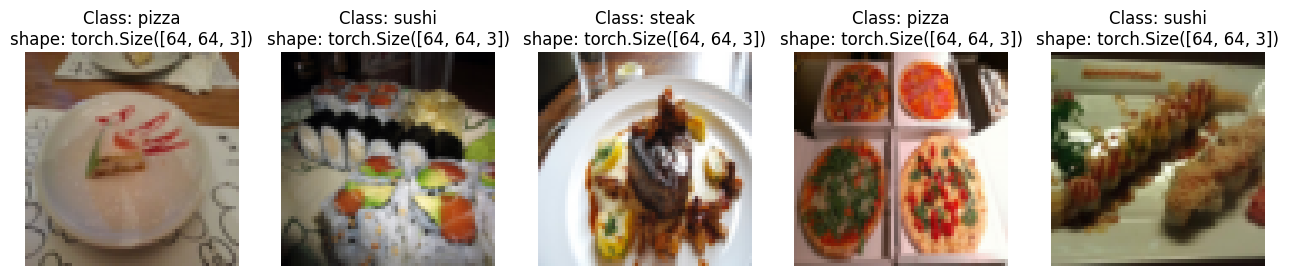

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_name,
                      seed=None)

### 5.4 Turn Custom loaded images into `DataLoader`S

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7bf855e1b910>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf855803790>)

In [ ]:
#Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
#print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6.Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.


In the case of image data, this may mean applying various image transformations to the training images.


This practice hopefully results in a model that's more generalizable to unseen data.


Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [ ]:
# 6. รูปแบบอื่นของการแปลงข้อมูล (data augmentation)

# Data augmentation คือกระบวนการเพิ่มความหลากหลายให้กับข้อมูลการฝึกของคุณอย่างประดิษฐ์

# ในกรณีของข้อมูลภาพ นี่อาจหมายถึงการใช้การแปลงภาพต่างๆ กับภาพการฝึก

# การปฏิบัตินี้หวังว่าจะทำให้โมเดลสามารถทั่วไปกับข้อมูลที่ไม่เคยเห็นมาก่อน

# ลองมาดูที่หนึ่งในประเภทของ data augmentation ที่ใช้ฝึกโมเดล PyTorch vision ให้มีประสิทธิภาพระดับสูงสุด...

In [ ]:
from torchvision import transforms
train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor()])


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

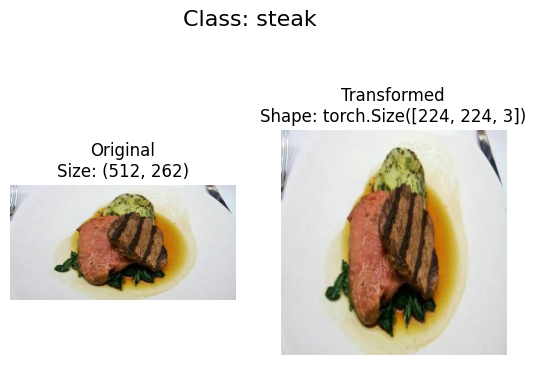

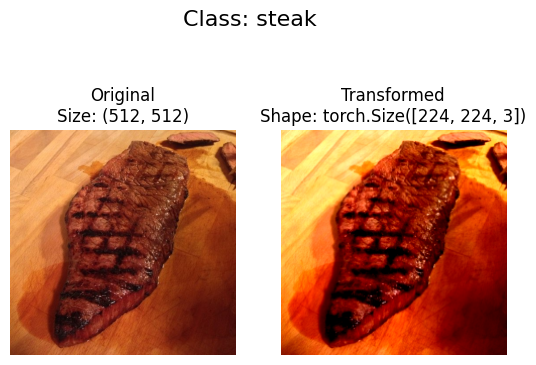

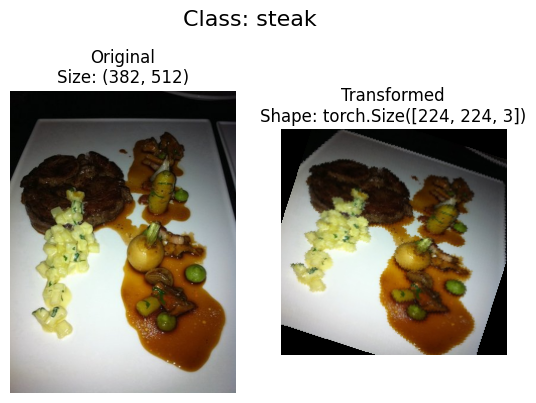

In [ ]:
#Plot random tranform img
plot_transformed_images(
    image_paths=image_paths_list,
    transform=train_transform,
    n=3,
    seed=None
)

##7.Model 0: tinyVGG wuthout data augmentation
Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

###7.1 Creating transforms and loading data for Model 0

In [ ]:
#create asimple transform
simple_transform = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])


In [ ]:
#1.Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)
#2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#srtup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
#create dataloader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7bf855e1b910>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf855803790>)

###7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    padding = 0
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                        stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                        stride=2) # default stride value is same as kernel_size
    )
    self.classsifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self, X):
    X = self.conv_block_1(X)
    # print(X.shape)
    X = self.conv_block_2(X)
    # print(X.shape)
    X = self.classsifier(X)
    # print(X.shape)
    return X
   # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_name)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classsifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

###7.3Try a forward pass on a single img (to test the model)


In [ ]:
#Get a single image batch
image_batch, lable_batch = next(iter(train_dataloader_simple))
image_batch.shape, lable_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
#try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

###7.4 Use torchinfo to get an idea of the shapes going through our model

In [ ]:
#install torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

###7.5 create train test loop function

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
#Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               optimzer:torch.optim.Optimizer,
               device = device):
  # Put the model in train model
  model.train()
  #setup train loss and train acc
  train_loss, train_acc = 0, 0
  #loop
  for batch, (X,y) in enumerate(dataloader):
    #send data to the target device
    X,y = X.to(device),y.to(device)
    #1. Forward pass
    y_pred = model(X) # output model logits
    #2.Calculete the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    #3.optimizer zero grad
    optimzer.zero_grad()
    #4. loss backward
    loss.backward()
    #5.optim step
    optimzer.step()
    #cal acc metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
 # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss,train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

###7.6 Creating a train() function to combine `train_step()` and `test_step()`

In [ ]:
# Setup loss and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model_0.parameters(),
#                              lr=0.1)

In [ ]:
# Measure time
# Import tqdm for progress bar
from tqdm.auto import tqdm
# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
  #2.create empty result dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
# 3. loop
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimzer=optimizer,
                                      device=device)
    test_loss,test_acc = test_step(model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results



###7.7 Train and evaluate model 0

In [ ]:
#set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#set num of epoch
NUM_EPOCHS = 5
#recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
#setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
#start the timer
from timeit import default_timer as timer
start_time = timer()
#train model

model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time : {end_time-start_time:.3f} srconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
Total training time : 11.056 srconds


In [ ]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

###7.8 Plot the loss curves of Model 0
A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [ ]:
#get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

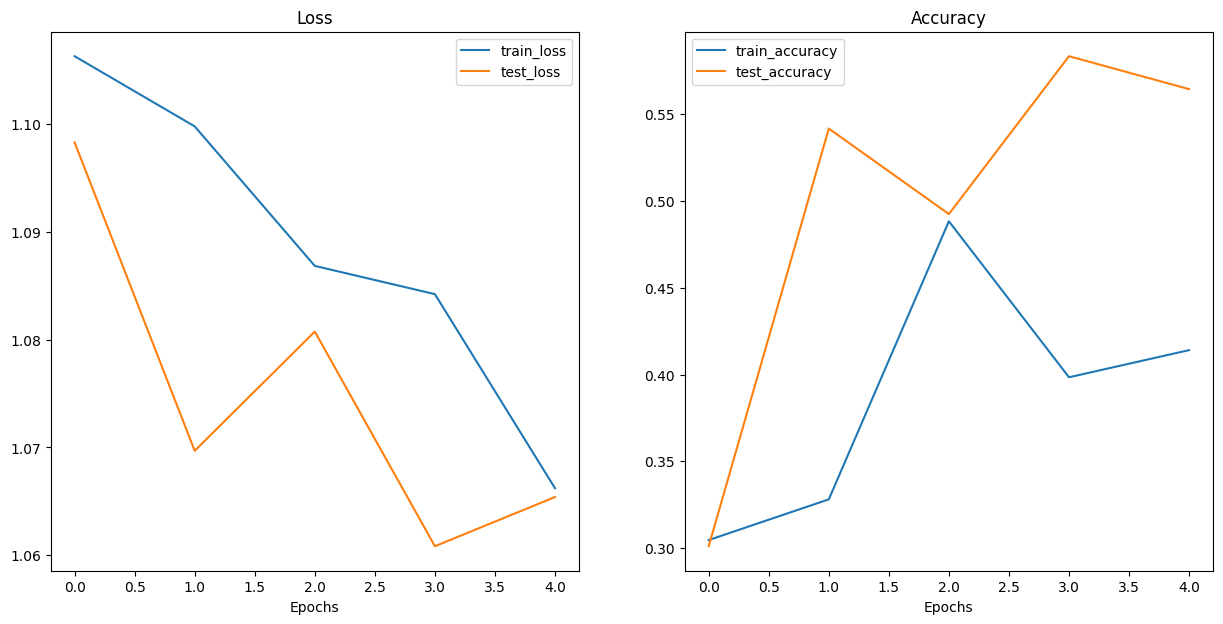

In [ ]:
plot_loss_curves(model_0_results)

## 8.What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

##9.Model 1: TinyVGG with Data Augmentation
Now let's try another modelling experiment this time using the same model as before with some data augmentation.

**Data Augmentation** คือการเพิ่มความหลากหลายให้กับข้อมูลการฝึกของโมเดล Machine Learning อย่างประดิษฐ์ โดยการใช้เทคนิคต่างๆ เช่น การหมุนภาพ, การพลิกภาพ, การเปลี่ยนแสง, และการครอบตัดภาพ เพื่อสร้างชุดข้อมูลใหม่จากข้อมูลเดิม วิธีนี้ช่วยเพิ่มประสิทธิภาพของโมเดลและลดปัญหา overfitting ทำให้โมเดลทั่วไปได้ดีกับข้อมูลที่ไม่เคยเห็นมาก่อน.

###9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

In [ ]:
"""`
transforms.TrivialAugmentWide` เป็นเทคนิคการเพิ่มความหลากหลายของข้อมูล (Data Augmentation)
ใน PyTorch ซึ่งใช้การแปลงภาพอย่างง่ายๆ หลายรูปแบบ เพื่อสร้างชุดข้อมูลฝึกที่หลากหลายมากขึ้น ตัวอย่างของการแปลงภาพที่ใช้ ได้แก่:
1. การหมุนภาพ (Rotation)
2. การครอบตัด (Cropping)
3. การเปลี่ยนสี (Color Jitter)
4. การปรับแสงและเงา (Brightness and Contrast Adjustment)
5. การสะท้อนภาพ (Horizontal and Vertical Flip)
6. การบิดเบือนภาพ (Distortion)

โดยมีการสุ่มระดับความรุนแรงของการแปลงภาพเหล่านี้เพื่อให้ได้ภาพที่หลากหลาย.

`transforms.TrivialAugmentWide(num_magnitude_bins=31)` ใช้พารามิเตอร์ `num_magnitude_bins` เพื่อกำหนดจำนวนระดับความรุนแรงของการแปลงข้อมูล (augmentation).

- **`num_magnitude_bins=31`** หมายถึงมี 31 ระดับความรุนแรงของการแปลงภาพ เช่น การหมุนภาพอาจมีตั้งแต่ระดับเล็กน้อยจนถึงระดับสูง
การปรับแสงอาจมีตั้งแต่เปลี่ยนแสงเล็กน้อยจนถึงเปลี่ยนแสงมาก
การมีหลายระดับเช่นนี้ช่วยให้การแปลงภาพมีความหลากหลายมากขึ้น ช่วยให้โมเดลเรียนรู้ได้ดีขึ้นและทั่วไปกับข้อมูลที่ไม่เคยเห็นมาก่อนได้ดีขึ้น.
ค่าต่ำสุดคือ 1 สูงสุด -
"""

###9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

###9.3Construct and train model 1
This time we'll be using the same model architecture except this time we've augmented the training data.

In [ ]:
#create model_1 and send it to thr target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classsifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our train() function to train and evaluate our model.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 20

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1062 | Train acc: 0.2917 | Test loss: 1.1060 | Test acc: 0.3125
Epoch: 1 | Train loss: 1.0938 | Train acc: 0.3875 | Test loss: 1.1101 | Test acc: 0.3125
Epoch: 2 | Train loss: 1.0948 | Train acc: 0.3875 | Test loss: 1.1173 | Test acc: 0.3125
Epoch: 3 | Train loss: 1.1038 | Train acc: 0.3250 | Test loss: 1.1145 | Test acc: 0.3125
Epoch: 4 | Train loss: 1.0935 | Train acc: 0.4083 | Test loss: 1.1135 | Test acc: 0.3375
Epoch: 5 | Train loss: 1.0907 | Train acc: 0.4417 | Test loss: 1.0930 | Test acc: 0.3625
Epoch: 6 | Train loss: 1.0590 | Train acc: 0.4875 | Test loss: 1.0741 | Test acc: 0.4182
Epoch: 7 | Train loss: 1.0491 | Train acc: 0.4458 | Test loss: 1.1529 | Test acc: 0.3625
Epoch: 8 | Train loss: 1.0491 | Train acc: 0.4583 | Test loss: 1.0448 | Test acc: 0.5102
Epoch: 9 | Train loss: 0.9914 | Train acc: 0.5708 | Test loss: 1.0005 | Test acc: 0.4409
Epoch: 10 | Train loss: 0.9648 | Train acc: 0.5792 | Test loss: 1.0454 | Test acc: 0.3670
Epoch: 11 | Train lo

###9.4 Plot the loss curves of model 1
A loss curve helps you evaluate your models performance overtime.

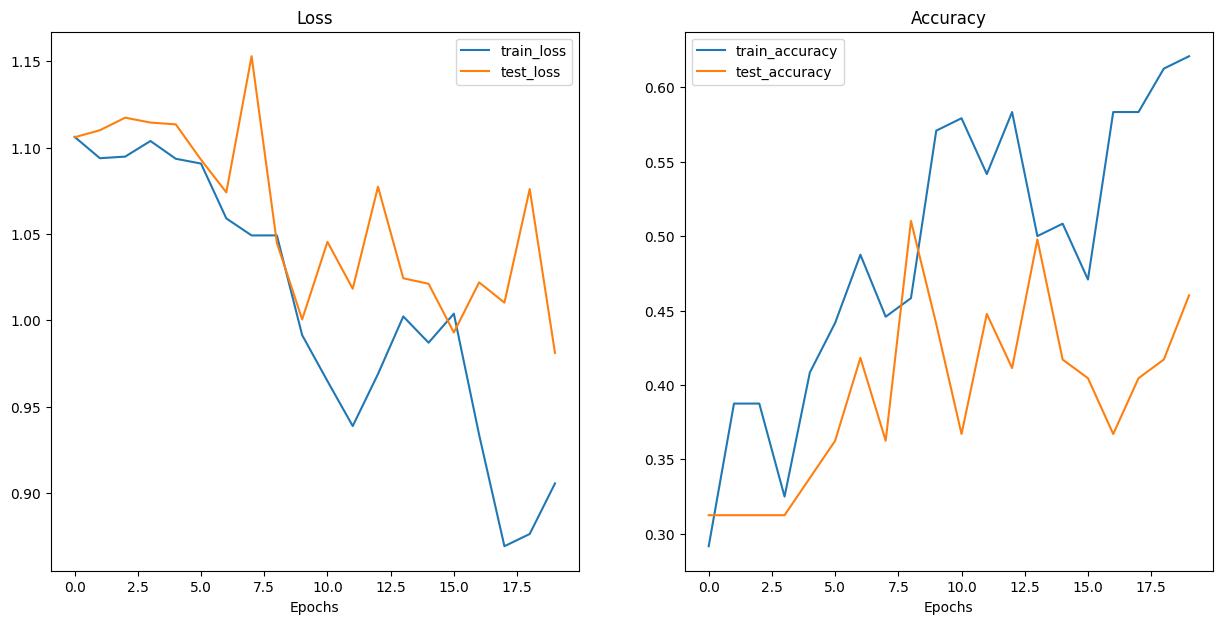

In [ ]:
plot_loss_curves(model_1_results)

##10.Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

* Hard coding (what we're doing)
* PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
* Weights & Biases - https://wandb.ai/site/experiment-tracking
* MLFlow - https://mlflow.org/

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099806   0.328125   1.069690  0.541667
2    1.086854   0.488281   1.080757  0.492424
3    1.084233   0.398438   1.060832  0.583333
4    1.066216   0.414062   1.065396  0.564394

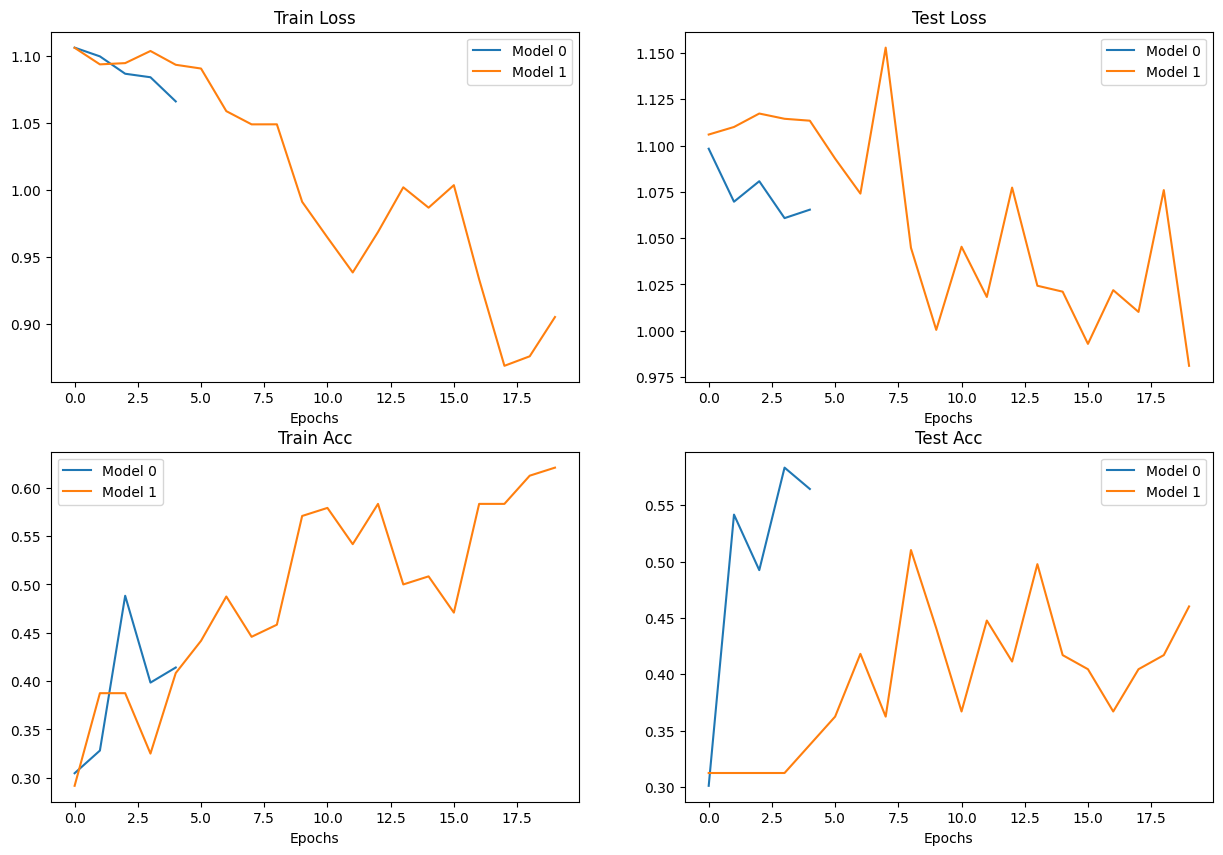

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs_0 = range(len(model_0_df))
epochs_1 = range(len(model_1_df))
# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs_0, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs_1, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs_0, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs_1, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs_0, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs_1, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs_0, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs_1, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

##11.Making a prediction on a custom image
Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "Sushi.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://fusedbyfionauyema.com/wp-content/uploads/2021/02/Fused-by-Fiona-Uyema-Sushi-Q-A-how-to-make-sushi-at-home.jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

###11.Loading in a custom image with PyTorch
We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device
* We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [ ]:
data_path

PosixPath('data')

In [ ]:
custom_image_path

PosixPath('data/Sushi.jpeg')

In [ ]:
import torchvision
import os

# Check if the file exists and is not empty
if os.path.exists(custom_image_path) and os.path.getsize(custom_image_path) > 0:
    custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
    print(custom_image_unit8)
    print(f"Custom image shape: {custom_image_unit8.shape}")
    print(f"Custom image datatype: {custom_image_unit8.dtype}")
    print(f"Custom image device: {custom_image_unit8.device}")
else:
    print(f"Error: File not found or empty: {custom_image_path}")
    # Consider re-downloading the image or checking the file path

tensor([[[  0,   0,   0,  ...,  43,  44,  48],
         [  0,   1,   1,  ...,  49,  48,  48],
         [  1,   1,   1,  ...,  51,  52,  52],
         ...,
         [177, 174, 170,  ...,  35,  36,  31],
         [163, 162, 160,  ...,  29,  34,  33],
         [153, 153, 154,  ...,  26,  27,  24]],

        [[  0,   0,   0,  ...,  46,  47,  51],
         [  0,   1,   1,  ...,  52,  51,  51],
         [  1,   1,   1,  ...,  54,  55,  55],
         ...,
         [ 70,  69,  67,  ...,  36,  37,  32],
         [ 62,  61,  61,  ...,  30,  35,  34],
         [ 55,  55,  57,  ...,  27,  28,  25]],

        [[  2,   2,   2,  ...,  53,  54,  58],
         [  2,   3,   3,  ...,  59,  58,  58],
         [  3,   3,   3,  ...,  61,  62,  62],
         ...,
         [ 26,  24,  24,  ...,  40,  41,  36],
         [ 18,  17,  19,  ...,  34,  39,  38],
         [ 10,  10,  15,  ...,  31,  32,  29]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 500, 750])
Custom image datatype: torch.uint8
Custom

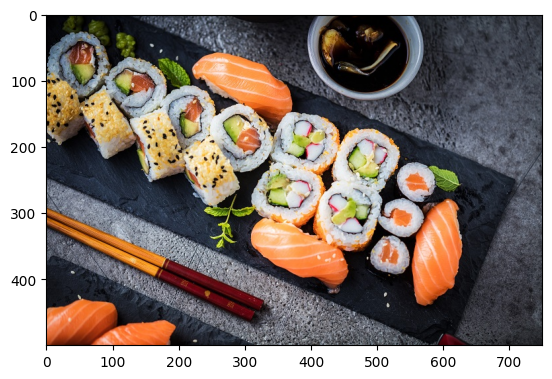

In [ ]:
plt.imshow(custom_image_unit8.permute(1, 2, 0))

###11.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
#try to make prediction on img in unit8 format

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1_pred = model_1(custom_image_unit8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
#convert img into torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1686, 0.1725, 0.1882],
         [0.0000, 0.0039, 0.0039,  ..., 0.1922, 0.1882, 0.1882],
         [0.0039, 0.0039, 0.0039,  ..., 0.2000, 0.2039, 0.2039],
         ...,
         [0.6941, 0.6824, 0.6667,  ..., 0.1373, 0.1412, 0.1216],
         [0.6392, 0.6353, 0.6275,  ..., 0.1137, 0.1333, 0.1294],
         [0.6000, 0.6000, 0.6039,  ..., 0.1020, 0.1059, 0.0941]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.1804, 0.1843, 0.2000],
         [0.0000, 0.0039, 0.0039,  ..., 0.2039, 0.2000, 0.2000],
         [0.0039, 0.0039, 0.0039,  ..., 0.2118, 0.2157, 0.2157],
         ...,
         [0.2745, 0.2706, 0.2627,  ..., 0.1412, 0.1451, 0.1255],
         [0.2431, 0.2392, 0.2392,  ..., 0.1176, 0.1373, 0.1333],
         [0.2157, 0.2157, 0.2235,  ..., 0.1059, 0.1098, 0.0980]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.2078, 0.2118, 0.2275],
         [0.0078, 0.0118, 0.0118,  ..., 0.2314, 0.2275, 0.2275],
         [0.0118, 0.0118, 0.0118,  ..., 0.2392, 0.2431, 0.

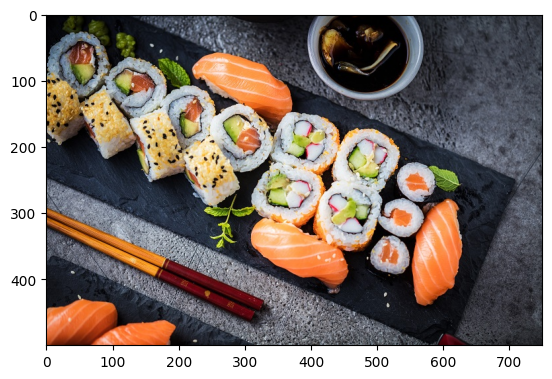

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0))

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1_pred = model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x48960 and 1690x3)

In [ ]:
#create transform pipline to resize img
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                            transforms.Resize(size=(64, 64))
])
custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape : {custom_image.shape}")
print(f"Transformed shape : {custom_image_transformed.shape}")

Original shape : torch.Size([3, 500, 750])
Transformed shape : torch.Size([3, 64, 64])


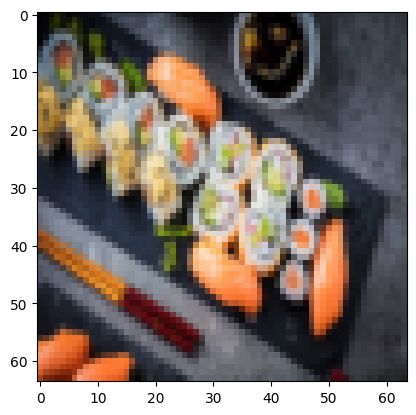

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  model_1_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [ ]:
custom_image_transformed.shape,custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# This work add batch size
model_1.eval()
with torch.inference_mode():
  custom_image_predition = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_predition

tensor([[-0.0919, -0.7180,  0.0573]])

In [ ]:
class_name

['pizza', 'steak', 'sushi']

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
#convert logits -> prediction probabilities
custom_image_predition_probs = torch.softmax(custom_image_predition, dim=1)
custom_image_predition_probs

tensor([[0.3710, 0.1984, 0.4307]])

In [ ]:
#convert pred to pred lable
custom_image_predition_label = torch.argmax(custom_image_predition_probs, dim=1)
custom_image_predition_label

tensor([2])

In [ ]:
class_name[custom_image_predition_label]

'sushi'

###11.3 Putting custom image prediction together: building a function
Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def predict_and_plot(model: torch.nn.Module,
                     image_path: str,
                     class_names: List[str] = None,
                     transform = None,
                     device: torch.device = device):
  #load img for prediction
  target_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
  target_image = target_image / 255.
  #transform
  if transform:
    target_image = transform(target_image)
  #send model to device
  model.to(device)
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)
    target_image_pred = model(target_image.to(device))
  #convert logits -> pred
  target_image_pred_prob = torch.softmax(target_image_pred, dim=1)
  #convert pred to pred lable
  target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_name:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_prob.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

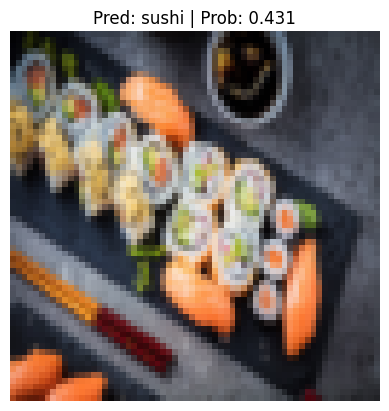

In [ ]:
#pred on custome image
predict_and_plot(model=model_1,
                 image_path=custom_image_path,
                 class_names=class_name,
                 transform=custom_image_transform,
                 device=device)